## Author: Paweł Jelonek <br> Date: 13.06.2021
### Machine learning course:<br> Lecture 5 - Unattended learning + feature engineering + team methods

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from sklearn.utils.fixes import parse_version
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KernelDensity
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

sns.set(style="white")
warnings.filterwarnings("ignore")


# plt.rcParams["figure.figsize"]=(20, 10)

Proszę opracować paradygmaty uczenia nienadzorowanego:
1.	klasteryzacja
2.	szacowanie gęstości rozkładu (kernel density estimation)
3.	detekcja wartości odstających

Inżynieria cech:
4.	metody selekcji cech
5.	zmniejszanie wymiarowości danych

Proszę opracować paradygmaty uczenia zespołowego:
6.	bagging
7.	boosting
8.	lasy losowe

W ramach danego paradygmatu uczenia przedstawić:
-	podstawy teoretyczne (krótko)
-	metody/typy
-   parametry, regularyzację, optymalizację
-	implementację (własną lub biblioteczną): uczenie, predykcja (testowanie)
-	typowe metryki wraz z metodami ich wyliczania
-	wizualizację: zbioru/modelu
-	uczenie na wybranym zbiorze danych (przy wielu metodach w ramach paradygmatu, na różnych zbiorach danych)

### 1.  klasteryzacja

### podstawy teoretycznie
Metoda klastrowania k-średnich to nienadzorowana technika uczenia maszynowego wykorzystywana do identyfikowania
klastrów obiektów danych w zestawie danych. Istnieje wiele różnych rodzajów metod grupowania, ale k-średnie jest
jedną z najstarszych i najbardziej przystępnych. Te cechy sprawiają, że implementacja klastrów k-średnich w Pythonie
jest dość prosta, nawet dla początkujących programistów i analityków danych.

In [3]:
def k_means_clustering(x: np.ndarray, y: np.ndarray, title: str):
    plt.scatter(x[:,0], x[:,1], c=y, cmap='gist_rainbow')
    plt.xlabel('{} Length'.format(title), fontsize=18)
    plt.ylabel('{} Width'.format(title), fontsize=18)
    km = KMeans(n_clusters = 3, random_state=1)
    km.fit(x)
    #this will tell us to which cluster does the data observations belong.
    new_labels = km.labels_
    # Plot the identified clusters and compare with the answers
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    plot_k_means(x[:, 0], x[:, 1], y, axes, title ,'Actual', 'gist_rainbow', 0)
    plot_k_means(x[:, 0], x[:, 1], new_labels, axes, title , 'Predicted', 'jet', 1)
    plt.show()

In [4]:
def plot_k_means(x: np.ndarray, y: np.ndarray, color: np.ndarray, axes: np.ndarray, title: str, result: str, cmap: str, position: int):
    axes[position].scatter(x, y, c=color, cmap=cmap,edgecolor='k', s=150)
    axes[position].set_xlabel('{} length'.format(title), fontsize=18)
    axes[position].set_ylabel('{} width'.format(title), fontsize=18)
    axes[position].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[position].set_title('{}'.format(result), fontsize=18)

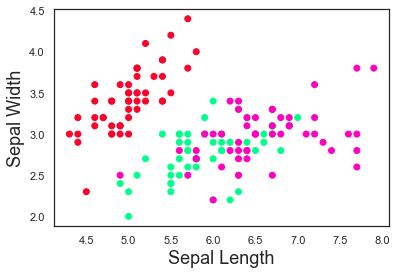

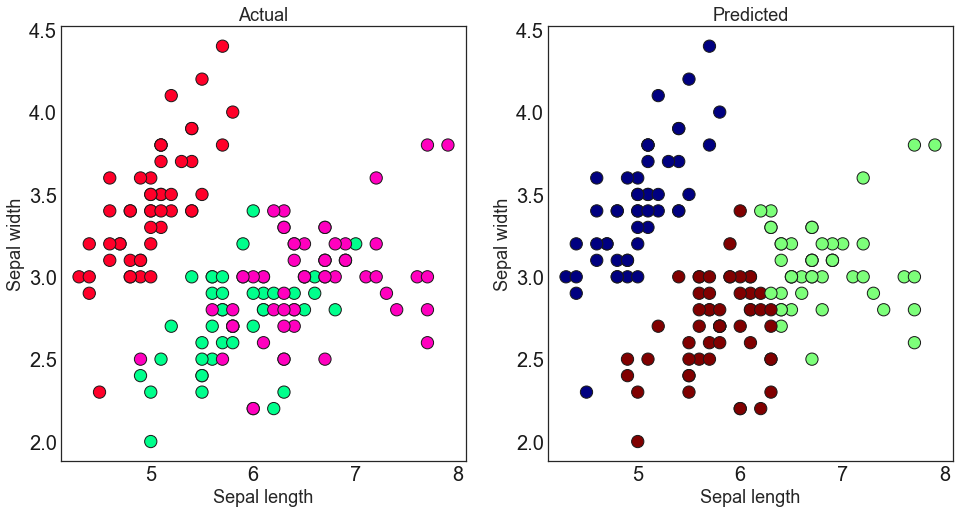

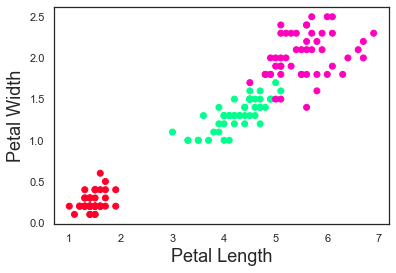

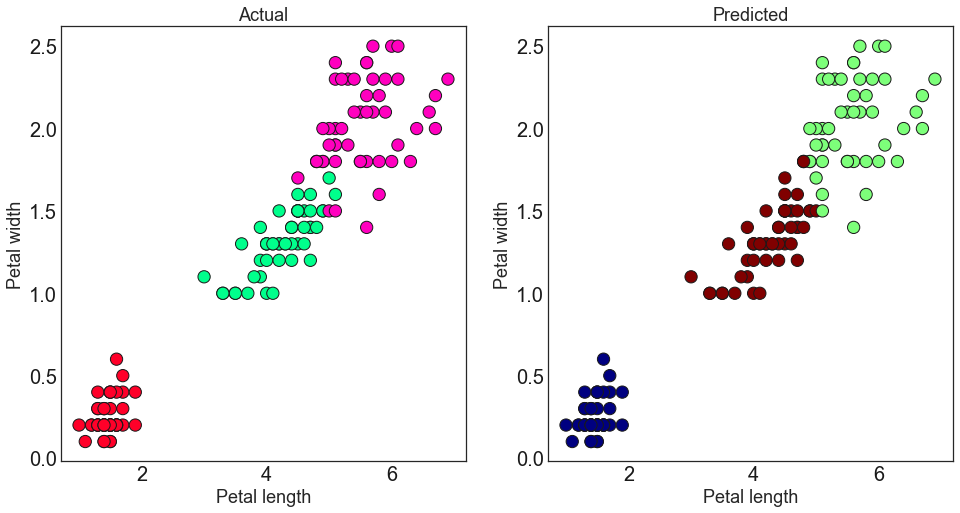

In [5]:
iris = datasets.load_iris()
k_means_clustering(iris.data[:, :2], iris.target, "Sepal")
k_means_clustering(iris.data[:, 2:4], iris.target, "Petal")

### 2.	szacowanie gęstości rozkładu (kernel density estimation)

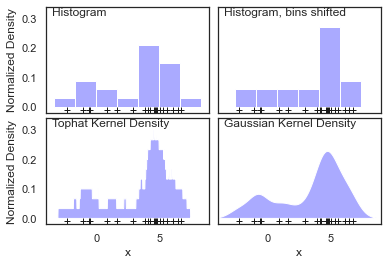

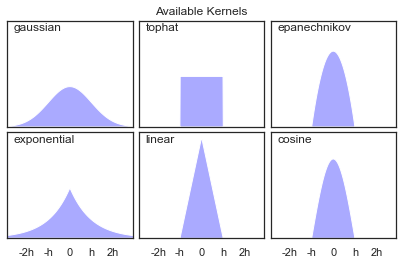

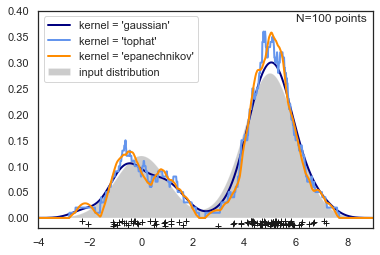

In [6]:

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

### 3.	detekcja wartości odstających

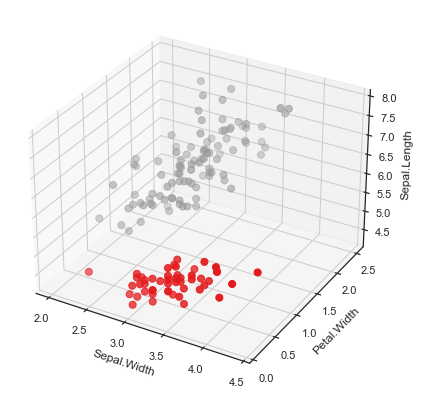

In [7]:
# library imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pydataset import data
from sklearn.cluster import DBSCAN
# import the data and remove any non-numeric columns
iris = pd.DataFrame(data('iris'))
iris = pd.DataFrame(iris.drop('Species', 1))
# apply DBSCAN clustering
db = DBSCAN(eps=0.9, min_samples=10).fit(iris)
iris['labels'] = db.labels_
# and plot the clusters
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iris['Sepal.Width'], iris['Petal.Width'], iris['Sepal.Length'],
c=iris['labels'], cmap='Set1', s=50)
ax.set_xlabel('Sepal.Width')
ax.set_ylabel('Petal.Width')
ax.set_zlabel('Sepal.Length')
plt.show()
plt.clf()
plt.cla()
plt.close()

### 4.  metody selekcji cech

In [8]:
data = pd.read_csv("train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

          Specs       Score
13     px_width  852.914979
14          ram  562.837207
0            id  223.566155
12    px_height   46.347162
9     mobile_wt   42.328627
5            fc   15.793117
11           pc   11.148155
7    int_memory    1.372252
3   clock_speed    1.052762
16         sc_w    0.809077


## 5.   zmniejszanie wymiarowości danych

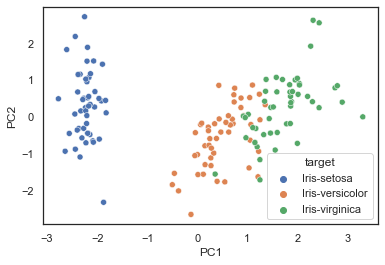

In [9]:

# import data from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

df.head()

X = df.iloc[:,0:4]
y = df.iloc[:,4]

# scale/normalize the data
X = StandardScaler().fit_transform(X)

# The two Principal Components
PCs = pd.DataFrame(PCA(n_components=2).fit_transform(X), columns = ['PC1', 'PC2'])

# add the target y to the data frame
PCs['target'] = y

sns.scatterplot(x='PC1', y='PC2', data=PCs, hue='target')
plt.show()

### 6.  bagging

### podstawy teoretycznie

Ensemble methods* are techniques that combine the decisions from several base machine learning (ML) models
to find a predictive model to achieve optimum results. Consider the fable of the blind men and the
elephant depicted in the image below. The blind men are each describing an elephant from their own point
of view. Their descriptions are all correct but incomplete. Their understanding of the elephant would be
more accurate and realistic if they came together to discuss and combined their descriptions.

The main principle of ensemble methods is to combine weak and strong learners to form strong and versatile learners.

This guide will introduce you to the two main methods of ensemble learning: bagging and boosting. Bagging
is a parallel ensemble, while boosting is sequential.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn import datasets # import inbuild datasets

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf = RandomForestClassifier(n_estimators=100)
bag_clf = BaggingClassifier(base_estimator=rf, n_estimators=100,bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.score(X_train,y_train), bag_clf.score(X_test,y_test)

(0.9904761904761905, 0.9333333333333333)

### 7.  boosting

In [11]:
gb = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
gb.fit(X_train, y_train)
gb.score (X_test,y_test),gb.score (X_train,y_train)

(0.9333333333333333, 1.0)